# Basic stock trading

In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta

In [2]:
# Your Alpha Vantage API key
api_key = '071XAV96TNY921'

# Define the ticker symbol
tickerSymbol = 'JBLU'  # Microsoft

# Define the API endpoint and parameters
base_url = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_DAILY',  # Retrieve daily time series
    'symbol': tickerSymbol,
    'apikey': api_key,
    'outputsize': 'full'  # Get the full-length time series
}

# Get the data from Alpha Vantage
response = requests.get(base_url, params=params)
data = response.json()

# Convert the JSON data into a Pandas DataFrame
tickerDf = pd.DataFrame(data['Time Series (Daily)']).T

# Convert index to datetime
tickerDf.index = pd.to_datetime(tickerDf.index)

# Filter data between specific dates
tickerDf = tickerDf[(tickerDf.index >= '2019-01-01') & (tickerDf.index <= '2020-04-10')]


In [3]:
tickerDf

,1. open,2. high,3. low,4. close,5. volume
2020-04-09,9.7500,10.3100,9.1400,9.5000,17219665
2020-04-08,9.0300,9.1500,8.7700,9.0300,12057438
2020-04-07,8.9600,9.4500,8.5511,8.7600,18291884
2020-04-06,7.8200,8.2300,7.2500,7.7300,13006342
2020-04-03,7.8000,7.9800,7.2200,7.4800,8196797
...,...,...,...,...,...
2019-01-08,16.8600,16.9300,16.6250,16.8500,3921922
2019-01-07,16.6400,16.9400,16.4000,16.6900,3188975
2019-01-04,16.1400,16.7800,16.0800,16.5500,4754136
2019-01-03,16.0100,16.0700,15.2900,15.9300,6430809


In [4]:
# Access the '1. open' column using bracket notation
priceData = tickerDf['1. open']

# Print the first few rows of priceData
print(priceData.head())

2020-04-09    9.7500
2020-04-08    9.0300
2020-04-07    8.9600
2020-04-06    7.8200
2020-04-03    7.8000
Name: 1. open, dtype: object


In [5]:
priceData=priceData.asfreq(pd.infer_freq(priceData.index))

In [6]:
priceData

2019-01-02    15.8000
2019-01-03    16.0100
2019-01-04    16.1400
2019-01-05        NaN
2019-01-06        NaN
               ...   
2020-04-05        NaN
2020-04-06     7.8200
2020-04-07     8.9600
2020-04-08     9.0300
2020-04-09     9.7500
Freq: D, Name: 1. open, Length: 464, dtype: object

In [7]:
print(priceData.isna().sum())  # Check for NaN values


143


In [8]:
priceData = priceData.dropna()


In [9]:
priceData = pd.to_numeric(priceData, errors='coerce')


Text(0.5, 1.0, 'JBLU Price Data')

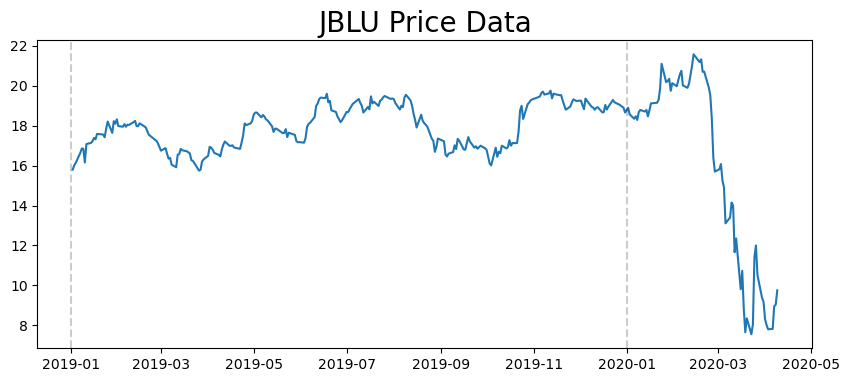

In [10]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

# Basic Buying Protocol
# -Buy if stock increasing for b consecutive days
# Basic Selling Protocols
# -Sell if stock decreasing for s consecutive days(and we've made a profit)

In [11]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [12]:
info_dict = get_buying_selling_days(priceData, 3, 3)


In [13]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [14]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [15]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

In [16]:
#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [17]:
df_stocks.head()

,buying_day,potential_selling_day,price
2019-01-07,True,False,16.64
2019-01-08,True,False,16.86
2019-01-15,True,False,17.22
2019-01-16,True,False,17.39
2019-02-21,False,True,17.55


In [18]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [19]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
      # Access the last element using iloc[-1]
    final_stock_price = price_data.iloc[-1]

    # Print the final stock price
    print(f"Final stock price: {final_stock_price}")

        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [20]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 600 shares at $16.64 on 2019-01-07 totaling $9984.0
Sold 600 shares at $17.55 on 2019-02-21 totaling $10530.0
--------------------------------------
Bought 626 shares at $16.84 on 2019-03-14 totaling $10541.84
Sold 626 shares at $18.27 on 2019-05-10 totaling $11437.02
--------------------------------------
Bought 632 shares at $18.09 on 2019-06-06 totaling $11432.88
Sold 632 shares at $18.46 on 2019-06-25 totaling $11666.72
--------------------------------------
Bought 605 shares at $19.28 on 2019-07-08 totaling $11664.4
Final stock price: 9.75


In [21]:
print(percent_change) ## it means we made a 5600$'s'

-0.41


(7.0, 22.0)

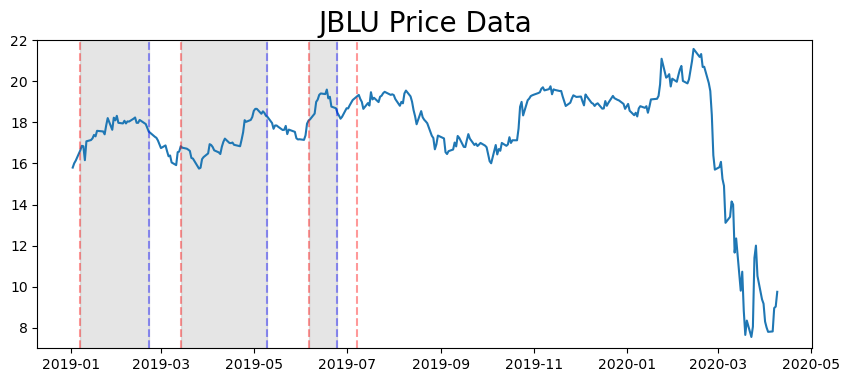

In [22]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)